In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import torch
import argparse

from zfa.models.raft.raft import RAFT
from zfa.models.raft.utils.utils import InputPadder, forward_interpolate
from zfa.models.paths import PATHS
from zfa.model_training.datasets import FramePairDataset
from zfa.core.default_dirs import MVK_FRAME_DIR, MVK_FLOW_DIR
from zfa.core.frame_utils import writeFlow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', default=PATHS["raft_sintel"], help="restore checkpoint")
parser.add_argument('--dataset', help="dataset for evaluation")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
args, _ = parser.parse_known_args()

In [3]:
args

Namespace(model='/om/weka/yanglab/anayebi/zfa/model_ckpts/raft/raft-sintel.pth', dataset=None, small=False, mixed_precision=False, alternate_corr=False)

In [4]:
args.model

'/om/weka/yanglab/anayebi/zfa/model_ckpts/raft/raft-sintel.pth'

In [9]:
def get_sequence_name(image_paths):
    # Check if the input is a tuple of length 2
    if not isinstance(image_paths, tuple) or len(image_paths) != 2:
        raise ValueError("Input must be a tuple of length 2")

    # Check if the sequence names are the same for both image paths
    directory1 = os.path.dirname(image_paths[0])
    directory2 = os.path.dirname(image_paths[1])
    sequence_name1 = os.path.basename(directory1)
    sequence_name2 = os.path.basename(directory2)
    if sequence_name1 != sequence_name2:
        raise ValueError("Sequence names in the input tuple are not the same")

    # Extract the sequence name
    return sequence_name1

def get_frame_name(image_path):
    # Extract the filename stem from the first image path
    filename = os.path.basename(image_path)
    frame_name = os.path.splitext(filename)[0]
    return frame_name

def get_flow_path(image_paths):
    # Check if the input is a tuple of length 2
    if not isinstance(image_paths, tuple) or len(image_paths) != 2:
        raise ValueError("Input must be a tuple of length 2")
        
    frame_name = get_frame_name(image_paths[0])
    flow_name = frame_name.replace("frame", "flow")
    flow_name += ".flo"
    # Replace directory part with MVK_FLOW_DIR
    flow_dir = os.path.dirname(image_paths[0]).replace(MVK_FRAME_DIR, MVK_FLOW_DIR)
    
    # Construct the full path of the flow file
    flow_path = os.path.join(flow_dir, flow_name)
    
    return flow_dir, flow_path

# iterations matching sintel eval: https://github.com/princeton-vl/RAFT/blob/master/evaluate.py#L96,
# as well as warm starting with flow of previous frame of same video: https://github.com/princeton-vl/RAFT/blob/master/evaluate.py#L184
@torch.no_grad()
def evaluate_mvk(model, mode, iters=32, warm_start=True):
    assert mode in ["train", "val", "test"]
    
    model.eval()
    # returns consecutive pairs
    d = FramePairDataset(root_dir=os.path.join(MVK_FRAME_DIR, mode))
    assert len(d) > 0
    
    # logic adapted from: https://github.com/princeton-vl/RAFT/blob/master/evaluate.py#L28-L49
    flow_prev, sequence_prev = None, None
#     for idx in range(len(d)):
    for idx in range(749,756):
        image1, image2 = d[idx]
        curr_image_paths = d.image_list[idx]
        sequence = get_sequence_name(curr_image_paths)
        # reinitialize flow for new videos
        if sequence != sequence_prev:
            print("New video: ", idx)
            flow_prev = None
        
        image1 = image1[None].cuda()
        image2 = image2[None].cuda()

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        flow_low, flow_pr = model(image1, image2, iters=iters, flow_init=flow_prev, test_mode=True)
        # since batch size is 1, we index into the batch dimension
        # originally, it is 2 x h x w, and then it becomes h x w x 2
        flow = padder.unpad(flow_pr[0]).permute(1, 2, 0).cpu().numpy()

        if warm_start:
            flow_prev = forward_interpolate(flow_low[0])[None].cuda()
                
        flow_dir, flow_path = get_flow_path(curr_image_paths)
        print(idx, flow_dir, flow_path)
        plt.imshow(flow[:, :, 0])
        plt.colorbar()
        plt.show()
        plt.imshow(flow[:, :, 1])
        plt.colorbar()
        plt.show()
#         if not os.path.exists(flow_dir):
#             os.makedirs(flow_dir)
#         writeFlow(flow_path, flow)
        
        sequence_prev = sequence

New video:  749
749 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Ambon_Apr2012_0005 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Ambon_Apr2012_0005/flow_000000000749.flo


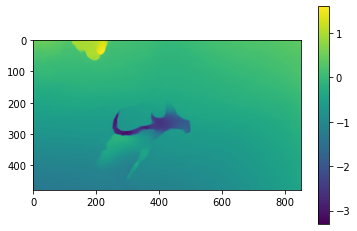

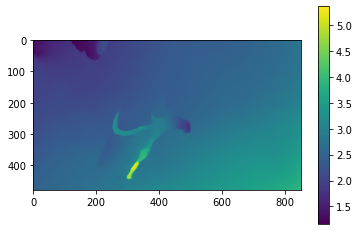

750 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Ambon_Apr2012_0005 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Ambon_Apr2012_0005/flow_000000000750.flo


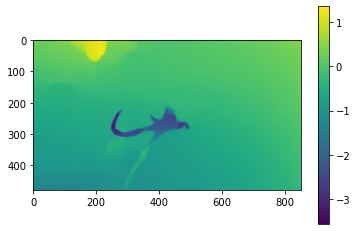

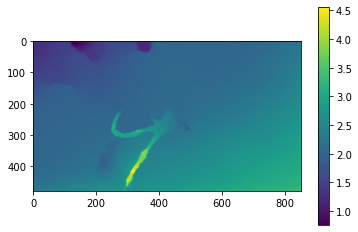

751 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Ambon_Apr2012_0005 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Ambon_Apr2012_0005/flow_000000000751.flo


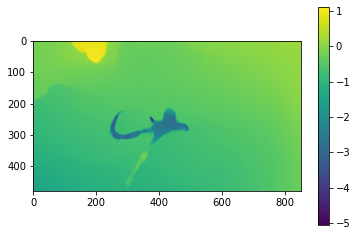

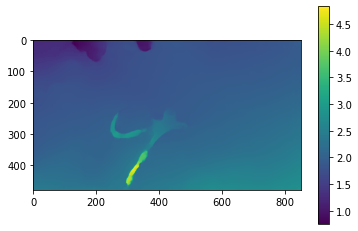

New video:  752
752 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Bali_Apr2014_0002 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Bali_Apr2014_0002/flow_000000000000.flo


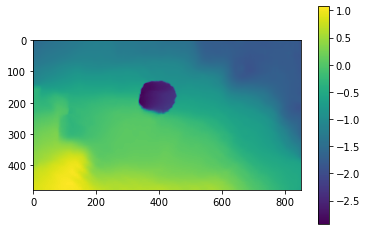

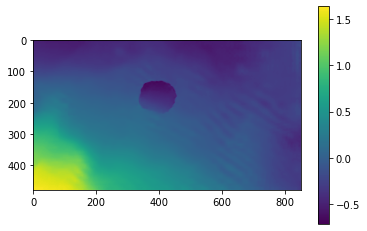

753 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Bali_Apr2014_0002 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Bali_Apr2014_0002/flow_000000000001.flo


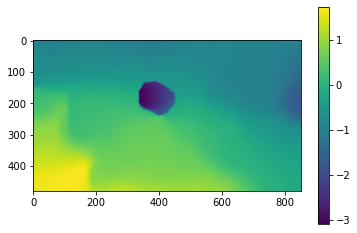

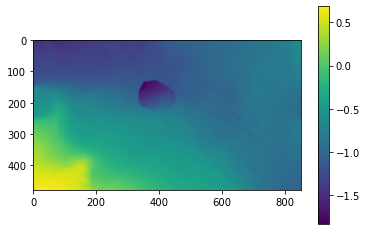

754 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Bali_Apr2014_0002 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Bali_Apr2014_0002/flow_000000000002.flo


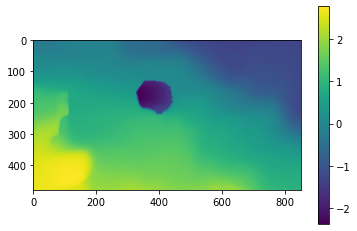

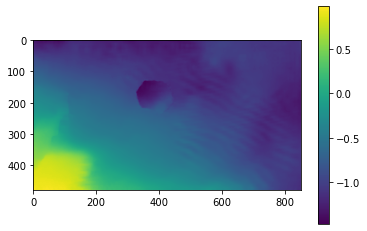

755 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Bali_Apr2014_0002 /om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Bali_Apr2014_0002/flow_000000000003.flo


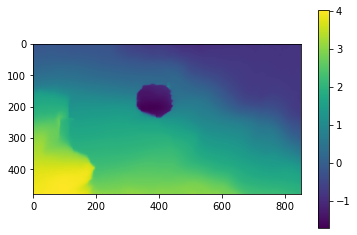

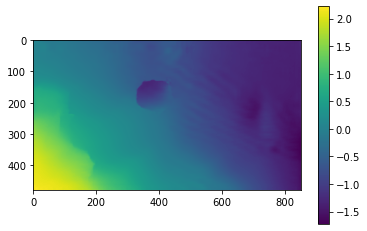

In [10]:
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))

model.cuda()
model.eval()

with torch.no_grad():
    evaluate_mvk(model.module, mode="val")

In [22]:
d = FramePairDataset(root_dir=os.path.join(MVK_FRAME_DIR, "val/"))

In [23]:
d.image_list

[('/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_000000000000.png',
  '/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_000000000001.png'),
 ('/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_000000000001.png',
  '/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_000000000002.png'),
 ('/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_000000000002.png',
  '/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_000000000003.png'),
 ('/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_000000000003.png',
  '/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_00000000

In [30]:
d.image_list[751]

('/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_000000000751.png',
 '/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/val/Ambon_Apr2012_0005/frame_000000000752.png')

In [42]:
# Example usage:
image_paths = d.image_list[751]

sequence_name = get_sequence_name(image_paths)
print(sequence_name)  # Output: Bali_Apr2014_0002


Ambon_Apr2012_0005


In [43]:
print(get_frame_name(image_paths[0]))

frame_000000000751


In [47]:
get_flow_path(d.image_list[751])

'/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Ambon_Apr2012_0005/flow_000000000751'

In [48]:
get_flow_path(d.image_list[752])

'/om/weka/yanglab/anayebi/zfa/pretraining_datasets/processed/MarineVideoKit/processed/MarineVideoKit_flows/val/Bali_Apr2014_0002/flow_000000000000'